# Truora

# 1 Author

**Student Name**:  Zheyun Zhao

**Student ID**:  221170559



# 2 Problem formulation

Describe the machine learning problem that you want to solve and explain what's interesting about it.

# 3 Methodology

Describe your methodology. Specifically, describe your training task and validation task, and how model performance is defined (i.e. accuracy, confusion matrix, etc). Any other tasks that might help you build your model should also be described here.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import keras
from keras import models, layers, callbacks
from typing import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import pandas as pd
import numpy as np
import joblib

In [2]:
class Config:
  def __init__(
      self,
      dataset_path: str = "../datasets/",
      story_path: str = "../datasets/CBU0521DD_stories/",
      augmented_story_path: str = "../datasets/CBU0521DD_stories/_augmented/",
      label_path: str = "../datasets/CBU0521DD_stories_attributes.csv",
      augmented_label_path: str = "../datasets/CBU0521DD_stories_attributes_augmented.csv",
      labels: List[str] = ["True Story", "Deceptive Story"],
      model_path: str = "../models/",
      epochs: int = 100,
      batch_size: int = 10,
  ):
    self.dataset_path = dataset_path
    self.story_path = story_path
    self.augmented_story_path = augmented_story_path
    self.label_path = label_path
    self.augmented_label_path = augmented_label_path
    self.labels = labels
    self.model_path = model_path
    self.epochs = epochs
    self.batch_size = batch_size

# 4 Implemented ML prediction pipelines

Describe the ML prediction pipelines that you will explore. Clearly identify their input and output, stages and format of the intermediate data structures moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. After providing an overview, describe in more detail each one of the stages that you have included in their corresponding subsections (i.e. 4.1 Transformation stage, 4.2 Model stage, 4.3 Ensemble stage).

## 4.1 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

In [3]:
class DataTransformer:
  """
  用于完成以下功能：
  1. 读取并加载数据（包括原始数据与增强数据）
  2. 对音频数据进行特征提取（Mel-Spectrogram, MFCC, Chroma等）
  3. 保存与加载NPZ格式的数据
  """

  def __init__(self, config: Config):
    self.config = config

  # Save features and labels to a .npz file
  def save_data(features, labels, file_path):
    np.savez(file_path, features=features, labels=labels)
    print(f"Dataset saved to: {file_path}")

  # 加载数据
  def load_data_from_npz(self, file_path):
    data = np.load(file_path)
    return data

  def load_data(self, dataset_path: str, labels_df: pd.DataFrame, augmented: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    filenames = self._get_filenames(labels_df, augmented)
    features, labels = [], []

    for filename in tqdm(filenames, desc="Loading data", ncols=100, unit="file"):
      file_path = os.path.join(dataset_path, filename)
      audio_features = self.extract_features(file_path)

      story_type = self._get_story_type(filename, labels_df, augmented)

      features.append(audio_features)
      labels.append(story_type)

    return {
      "features": np.array(features),
      "labels": np.array(labels),
    }

  def _get_filenames(self, labels_df: pd.DataFrame, augmented: bool) -> list:
    if augmented:
      augmented_labels_df = pd.read_csv(self.config.augmented_label_path)
      return augmented_labels_df["filename"].tolist()
    else:
      return labels_df["filename"].tolist()

  def _get_story_type(self, filename: str, labels_df: pd.DataFrame, augmented: bool) -> str:
    if augmented:
      augmented_labels_df = pd.read_csv(self.config.augmented_label_path)
      return augmented_labels_df[augmented_labels_df["filename"] == filename]["Story_type"].values[0]
    else:
      return labels_df[labels_df["filename"] == filename]["Story_type"].values[0]
    
  def get_datasets(self, load_from_npz: bool = True) -> List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    datasets = []
    if load_from_npz:
      train_data = self.load_data_from_npz(f"../datasets/train.npz")
      validation_data = self.load_data_from_npz(f"../datasets/validation.npz")
      test_data = self.load_data_from_npz(f"../datasets/test.npz")
      datasets.append((train_data["features"], train_data["labels"], validation_data["features"], validation_data["labels"], test_data["features"], test_data["labels"]))
    return datasets
      
  @staticmethod
  def extract_features(
      file_path: str,
      sr: int = 16000,
      n_mels: int = 128,
      duration: int = 240,
  ) -> np.ndarray:
    """
    提取音频特征，包括Mel-Spectrogram、MFCC、Chroma、ZCR、能量、持续时间、谱质心、滚降点等。
    最终将所有特征拼接到同一矩阵中，并做定长处理。
    """
    audio, sr = librosa.load(file_path, sr=sr)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    short_term_energy = np.sum(audio ** 2) / len(audio)
    duration_feature = len(audio) / sr

    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spectral_flux = librosa.onset.onset_strength(y=audio, sr=sr)

    features = np.vstack([
        log_mel_spectrogram,
        mfcc,
        chroma,
        zero_crossing_rate,
        spectral_centroid,
        spectral_rolloff,
        spectral_flux,
    ])

    target_length = int(sr * duration / 512)
    if features.shape[1] < target_length:
      padding = np.zeros((features.shape[0], target_length - features.shape[1]))
      features = np.concatenate([features, padding], axis=1)
    else:
      features = features[:, :target_length]

    additional_features = np.array([short_term_energy, duration_feature])
    additional_features = np.repeat(additional_features[:, np.newaxis], features.shape[1], axis=1)

    features = np.concatenate([features, additional_features], axis=0)

    return features

## 4.2 Model stage

Describe the ML model(s) that you will build. Explain why you have chosen them.

In [4]:
from abc import ABC, abstractmethod
from typing import Any, Optional

class BaseModel(ABC):
    """
    Abstract base class for models, supporting lifecycle management and core functionality.
    """

    def __init__(self):
        self.use = True
        self.model: Optional[Any] = None

    @abstractmethod
    def build(self, **kwargs) -> None:
        """
        Build the model architecture.
        """
        pass

    @abstractmethod
    def train(self, X_train: Any, y_train: Any, **kwargs) -> None:
        """
        Train the model on the provided data.
        """
        pass

    @abstractmethod
    def predict(self, X_test: Any) -> Any:
        """
        Generate predictions for the provided test data.
        """
        pass

    @abstractmethod
    def save(self, path: str) -> None:
        """
        Save the model to the specified path.
        """
        pass

    @abstractmethod
    def load(self, path: str) -> None:
        """
        Load the model from the specified path.
        """
        pass

    def get(self) -> Optional[Any]:
        """
        Retrieve the model instance if enabled.
        """
        return self.model if self.use else None

    def enable(self) -> None:
        """
        Enable the model for use.
        """
        self.use = True

    def disable(self) -> None:
        """
        Disable the model from being used.
        """
        self.use = False

In [5]:
from sklearn.neighbors import KNeighborsClassifier

class KNNModel(BaseModel):
    def __init__(self):
        super().__init__()

    def build(self, n_neighbors=5):
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
        return self.model

    def train(self, X_train, y_train):
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test):
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict(X_test_2d)

    def save(self, path):
        joblib.dump(self.model, path)

    def load(self, path):
        self.model = joblib.load(path)
        return self.model

In [6]:
from sklearn.linear_model import LogisticRegression

class LRModel(BaseModel):
    def __init__(self):
        super().__init__()

    def build(self, C=1.0, random_state=42, max_iter=100):
        self.model = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
        return self.model

    def train(self, X_train, y_train):
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test):
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict_proba(X_test_2d)[:, 1]

    def save(self, path):
        joblib.dump(self.model, path)

    def load(self, path):
        self.model = joblib.load(path)
        return self.model

In [7]:
from sklearn.ensemble import RandomForestClassifier

class RFModel(BaseModel):
    def __init__(self):
        super().__init__()

    def build(self, n_estimators=100, random_state=42):
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        return self.model

    def train(self, X_train, y_train):
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test):
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict_proba(X_test_2d)[:, 1]

    def save(self, path):
        joblib.dump(self.model, path)

    def load(self, path):
        self.model = joblib.load(path)
        return self.model

In [8]:
from sklearn.svm import SVC

class SVM(BaseModel):
    def __init__(self):
        super().__init__()

    def build(self, C=1.0, kernel='rbf'):
        self.model = SVC(C=C, kernel=kernel)
        return self.model

    def train(self, X_train, y_train):
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test):
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict(X_test_2d)

    def save(self, path):
        joblib.dump(self.model, path)

    def load(self, path):
        self.model = joblib.load(path)
        return self.model

In [9]:
import os
from typing import Tuple
from keras import layers, models, callbacks


def show_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


class NNModel(BaseModel):
    def __init__(self):
        super().__init__()

    def build(self, input_shape: Tuple[int, int, int]):
        model_input = layers.Input(shape=input_shape)

        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(model_input)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Reshape((1, 128))(x)  # (batch_size, sequence_length=1, feature_dim=128)
        attention_output = layers.Attention()([x, x])  # Self-Attention

        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(attention_output)
        x = layers.Bidirectional(layers.LSTM(64))(x)

        x = layers.Dense(64, activation="relu", kernel_regularizer="l2")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        output = layers.Dense(1, activation="sigmoid")(x)

        model = models.Model(inputs=model_input, outputs=output)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        self.model = model
        return self.model

    def train(self, X_train, y_train, x_val, y_val, model_path, epochs=10, batch_size=32):
        print(f"Training Neural Network ...")

        lr_scheduler = callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
        early_stopping = callbacks.EarlyStopping(monitor="loss", patience=100)
        model_checkpoint = callbacks.ModelCheckpoint(
            filepath=os.path.join(model_path, f"nn_model.keras"),
            monitor="val_accuracy",
            save_best_only=True
        )
        callbacks_list = [lr_scheduler, early_stopping, model_checkpoint]

        history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            callbacks=callbacks_list
        )
        show_history(history)

        return self.model

    def predict(self, X_test):
        return self.model.predict(X_test).flatten()

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = models.load_model(path)
        return self.model

In [10]:
class ModelBuilder:
  """
  负责构建与返回所需模型。
  目前包含：CNN-LSTM模型（带Attention）以及随机森林模型。
  """

  @staticmethod
  def build_nn_model(input_shape: Tuple[int, int, int]) -> models.Model:
    nn_model = NNModel()
    nn_model.build(input_shape)
    return nn_model

  @staticmethod
  def build_rf_model(random_state: int = 42, n_estimators: int = 100) -> RFModel:
    rf_model = RFModel()
    rf_model.build(random_state=random_state, n_estimators=n_estimators)
    return rf_model
  
  @staticmethod
  def build_knn_model(n_neighbors: int = 3) -> KNNModel:
    knn_model = KNNModel()
    knn_model.build(n_neighbors=n_neighbors)
    return knn_model

  @staticmethod
  def build_logistic_regression_model(C=1, random_state=42, max_iter=100) -> LRModel:
    lr_model = LRModel()
    lr_model.build(C=C, random_state=random_state, max_iter=max_iter)
    return lr_model
  
  @staticmethod
  def build_svm_model(C=1.0, kernel="rbf") -> SVM:
    svm_model = SVM()
    svm_model.build(C=C, kernel=kernel)
    return svm_model

## 4.3 Ensemble stage

Describe any ensemble approach you might have included. Explain why you have chosen them.

In [11]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str]):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cm_rearranged = np.array([[tp, fp],
                              [fn, tn]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_rearranged,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Actual class", fontsize=12)
    plt.ylabel("Predicted class", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.gca().xaxis.set_label_position("top")
    plt.gca().xaxis.tick_top()
    plt.show()


def plot_roc_curve(y_true: np.ndarray, y_pred_prob: np.ndarray):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("1 - Specificity (FPR)")
    plt.ylabel("Sensitivity (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

In [12]:
import numpy as np
from typing import Tuple

class Predictor:
    """
    用于模型预测及输出结果。包含集成预测的方法。
    """
    @staticmethod
    def ensemble_predict(
        X_test: np.ndarray,
        **kwargs
    ) -> Tuple[np.ndarray, np.ndarray]:
        model_list = ["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"]
        models = {k: v for k, v in kwargs.items() if k in model_list}

        if not any(models.values()):
            raise ValueError("At least one model is required!")

        predictions = []

        for model_name, model in models.items():
            if model is None or not model.use:
                continue
            preds = model.predict(X_test)
            predictions.append(preds)
            print(f"{model_name} Predictions: {preds}")

        num_sources = len(predictions)
        weights = kwargs.get("weights")
        if weights is None:
            weights = [1.0 / num_sources] * num_sources
        elif len(weights) != num_sources:
            raise ValueError("The number of weights must match the number of models used for prediction!")

        final_pred_prob = np.average(predictions, axis=0, weights=weights)
        final_pred = (final_pred_prob > 0.5).astype(int)

        return final_pred, final_pred_prob


In [13]:
class Evaluator:
    """
    对模型进行评估，包括指标计算、混淆矩阵与ROC曲线绘制等。
    """
    @staticmethod
    def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> None:
        report = classification_report(y_true, y_pred)
        print("Classification Report:\n", report)

        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        TN, FP, FN, TP = cm.ravel()

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        print(f"Sensitivity: {sensitivity:.2f}")
        print(f"Specificity: {specificity:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"F1 Score: {f1_score:.2f}")

    def evaluate_ensemble_model(
        self,
        *,
        X_test: np.ndarray,
        y_true: np.ndarray,
        labels: List[str],
        **kwargs
    ) -> Tuple[np.ndarray, np.ndarray]:
        final_pred, final_pred_prob = Predictor.ensemble_predict(X_test=X_test, **kwargs)
        print("\nEnsemble Model Evaluation:")
        self.evaluate_model(y_true, final_pred)
        plot_confusion_matrix(y_true, final_pred, labels=labels)
        plot_roc_curve(y_true, final_pred_prob)
        return final_pred, final_pred_prob

# 5 Dataset

Describe the datasets that you will create to build and evaluate your models. Your datasets need to be based on our MLEnd Deception Dataset. After describing the datasets, build them here. You can explore and visualise the datasets here as well. 

If you are building separate training and validatio datasets, do it here. Explain clearly how you are building such datasets, how you are ensuring that they serve their purpose (i.e. they are independent and consist of IID samples) and any limitations you might think of. It is always important to identify any limitations as early as possible. The scope and validity of your conclusions will depend on your ability to understand the limitations of your approach.

If you are exploring different datasets, create different subsections for each dataset and give them a name (e.g. 5.1 Dataset A, 5.2 Dataset B, 5.3 Dataset 5.3) .



In [14]:
import soundfile as sf

CONFIG = {
    "dataset_path": "../datasets/",
    "story_path": "../datasets/CBU0521DD_stories/",
    "label_path": "../datasets/CBU0521DD_stories_attributes.csv",
}

In [15]:
# Data augmentation methods: time stretch, pitch shift, add noise, change volume
def time_stretch(y, rate=1.2):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, n_steps=4):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_level=0.005):
    noise = np.random.randn(len(y))
    return y + noise_level * noise

def change_volume(y, factor=1.2):
    return y * factor

def process_audio(filename, story_path, sr=16000):
    y, _ = librosa.load(os.path.join(story_path, filename), sr=sr)
    
    augmented_audios = []
    augmented_audios.append(time_stretch(y))
    augmented_audios.append(pitch_shift(y, sr))
    augmented_audios.append(add_noise(y))
    augmented_audios.append(change_volume(y))

    return [y] + augmented_audios

In [16]:
label_df = pd.read_csv(CONFIG['label_path'])
filenames = label_df['filename'].tolist()

filenames[:5]

['00001.wav', '00002.wav', '00003.wav', '00004.wav', '00005.wav']

In [17]:
augmented_filenames = []
augmented_labels = []

augmented_story_path = CONFIG['story_path'] + "_augmented/"
if not os.path.exists(augmented_story_path):
    os.makedirs(augmented_story_path)

In [18]:
for filename in tqdm(filenames, desc="Processing audio files", unit="file"):
    augmented_audios = process_audio(filename, CONFIG['story_path'])

    for i, y in enumerate(augmented_audios):
        augmented_filename = filename.split('.')[0] + f"_augmented_{i}.wav"
        augmented_filenames.append(augmented_filename)
        augmented_labels.append(label_df[label_df['filename'] == filename]['Story_type'].values[0])

        # 保存增强后的音频
        sf.write(os.path.join(augmented_story_path, augmented_filename), y, 16000)

Processing audio files: 100%|██████████| 100/100 [02:37<00:00,  1.57s/file]


In [19]:
augmented_labels_df = pd.DataFrame({
    "filename": augmented_filenames,
    "Language": ['Chinese'] * len(augmented_filenames),
    "Story_type": augmented_labels
})

augmented_labels_df.to_csv(CONFIG['label_path'].replace('.csv', '_augmented.csv'), index=False)

print(f"Data augmentation complete. The new label file is saved at: {CONFIG['label_path'].replace('.csv', '_augmented.csv')}")

Data augmentation complete. The new label file is saved at: ../datasets/CBU0521DD_stories_attributes_augmented.csv


# 6 Experiments and results

Carry out your experiments here. Analyse and explain your results. Unexplained results are worthless.

In [20]:
class Pipeline:
    config: Config
    data_transformer: DataTransformer
    evaluator: Evaluator
    predictor: Predictor
    models_dict: Dict[str, BaseModel]
    label_encoder: LabelEncoder

    def __init__(
        self,
        config: Config,
        data_transformer: DataTransformer,
        evaluator: Evaluator,
        predictor: Predictor,
        model_list: Dict[str, BaseModel],
    ):
        self.config = config
        self.data_transformer = data_transformer
        self.evaluator = evaluator
        self.predictor = predictor
        self.models_dict = model_list if model_list else {
            "nn_model": NNModel(),
            "rf_model": RFModel(),
            "knn_model": KNNModel(),
            "lr_model": LRModel(),
            "svm_model": SVM(),
        }
        self.init_label_encoder(self.config.labels)

    def set_model(self, name: str, model):
        self.models_dict[name] = model

    def init_label_encoder(self, labels: List[str]):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)
        self.labels = self.label_encoder.classes_

    def data_preprocessing(self, load_from_npz: bool = False, augmented: bool = False) -> List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,np.ndarray]]:
        if load_from_npz:
            

        for i, (X_train, y_train, X_val, y_val, X_test, y_test) in enumerate(datasets):
            y_train_encoded = self.label_encoder.transform(y_train)
            y_val_encoded = self.label_encoder.transform(y_val)
            y_test_encoded = self.label_encoder.transform(y_test)

            datasets[i] = (X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded)

        return datasets

    def train_model(
        self,
        model_name: str,
        model: BaseModel,
        X_train: np.ndarray,
        y_train: np.ndarray,
        *args,
        **kwargs
    ) -> BaseModel:
        model.train(X_train, y_train, *args, **kwargs)
        self.set_model(model_name, model)
        return model
    
    def load_model(self, model_name: str, model_path: str):
        model = self.models_dict[model_name]

        if not os.path.exists(model_path):
            raise FileNotFoundError(f"指定的模型路径 {model_path} 不存在。")

        print(f"Loading model: {model_name} from {model_path}")
        model.load(model_path)
        print(f"Model {model_name} successfully loaded.")

        # 更新到模型字典中
        self.set_model(model_name, model)
        return model
    
    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray, test_models: list[str]):
        """
        适配 evaluate_ensemble_model 的通用评估方法。
        对传入的模型名称启用对应的模型，并进行集成评估。
        """
        # 启用传入的模型，禁用其他模型
        for name, model in self.models_dict.items():
            if name in test_models:
                model.enable()
            else:
                model.disable()

        enabled_models = {
            name: model for name, model in self.models_dict.items() if model.get() is not None
        }

        if not enabled_models:
            raise ValueError("没有启用的模型可供评估，请至少启用一个模型。")

        print(f"Enabled models for evaluation: {list(enabled_models.keys())}")

        final_pred, final_pred_prob = self.evaluator.evaluate_ensemble_model(
            X_test=X_test,
            y_true=y_test,
            labels=self.config.labels,
            **enabled_models
        )

        predicted_labels = self.label_encoder.inverse_transform(final_pred)
        true_labels = self.label_encoder.inverse_transform(y_test)

        results = {
            "True Labels": true_labels,
            "Predicted Labels": predicted_labels,
            "Predicted Probabilities": final_pred_prob,
        }

        results_df = pd.DataFrame(results)

        print("\nEnsemble Model Evaluation Results:")
        return results_df
    
    def predict_audio(self, audio_path: str):
        audio_features = self.data_transformer.extract_features(audio_path)
        audio_features = audio_features[np.newaxis, ..., np.newaxis]

        final_pred, final_pred_prob = self.predictor.ensemble_predict(X_test=audio_features, **self.models_dict)
        predicted_label = self.label_encoder.inverse_transform(final_pred)[0]
        print(f"Predicted label: {predicted_label}")
        return predicted_label

In [21]:
config = Config(
    dataset_path="../datasets/",
    story_path="../datasets/CBU0521DD_stories/",
    augmented_story_path="../datasets/CBU0521DD_stories/_augmented/",
    label_path="../datasets/CBU0521DD_stories_attributes.csv",
    augmented_label_path="../datasets/CBU0521DD_stories_attributes_augmented.csv",
    model_path="../models/",
    epochs=100,
    batch_size=10,
    labels=["True Story", "Deceptive Story"]
)

data_transformer = DataTransformer(config)
model_builder = ModelBuilder()
evaluator = Evaluator()
predictor = Predictor()
model_list = {
    "nn_model": NNModel(),
    "rf_model": RFModel(),
    "knn_model": KNNModel(),
    "lr_model": LRModel(),
    "svm_model": SVM(),
}

pipeline = Pipeline(config=config, data_transformer=data_transformer, evaluator=evaluator, predictor=predictor, model_list=model_list)

In [22]:
datasets = pipeline.data_preprocessing(load_from_npz=True, augmented=True)

Labels: ['Deceptive Story' 'True Story']
Original dataset size: 100
Augmented dataset size: 500
Number of datasets created: 5


In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets[0]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((420, 166, 7500, 1),
 (420,),
 (90, 166, 7500, 1),
 (90,),
 (90, 166, 7500, 1),
 (90,))

2024-12-25 02:48:21.693361: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 02:48:21.699195: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-25 02:48:21.711308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735066101.729466   15612 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735066101.734680   15612 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

Training Neural Network ...


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([10, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.5463 - loss: 1.4439 - val_accuracy: 0.4444 - val_loss: 1.2219 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - accuracy: 0.4792 - loss: 1.2036 - val_accuracy: 0.4333 - val_loss: 1.0340 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.5946 - loss: 0.9680 - val_accuracy: 0.6111 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.5535 - loss: 0.9075 - val_accuracy: 0.5889 - val_loss: 0.8417 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.6415 - loss: 0.7918 - val_accuracy: 0.5778 - val_loss: 0.8005 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.5700 - loss: 0.7796 - val_accuracy: 0.3778 - val_loss: 0.7922 - learning_rate: 0.0010
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.6034 - l

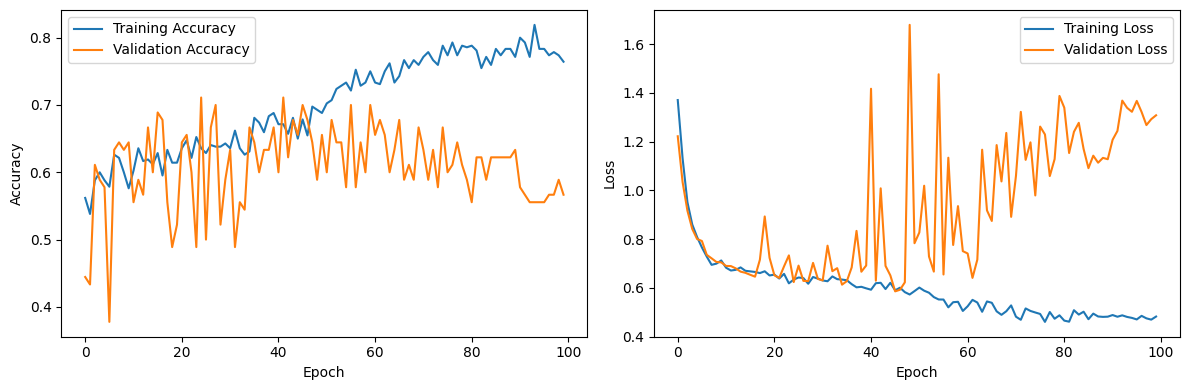

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 166, 7500, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 166, 7500, │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 166, 7500, │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 83, 3750,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 83, 3750,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 83, 3750,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 83, 3750,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 41, 1875,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 41, 1875,  │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 41, 1875,  │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 1875,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 128)    │          0 │ reshape[0][0],    │
│ (Attention)         │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1, 256)    │    263,168 │ attention[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,587,845 (6.06 MB)

 Trainable params: 529,089 (2.02 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 1,058,180 (4.04 MB)

In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets[0]
nn_model = model_builder.build_nn_model(input_shape=X_train[0].shape)
pipeline.train_model(model_name="nn_model", model=nn_model, X_train=X_train, y_train=y_train, x_val=X_val, y_val=y_val, model_path=config.model_path, epochs=config.epochs, batch_size=config.batch_size)
nn_model.model.summary()

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets[1]
rf_model = model_builder.build_rf_model(random_state=42, n_estimators=100)
pipeline.train_model(model_name="rf_model", model=rf_model, X_train=X_train, y_train=y_train)
rf_model.save(os.path.join(config.model_path, "rf_model.joblib"))
rf_model.model

RandomForestClassifier(random_state=42)

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets[2]
knn_model = model_builder.build_knn_model(n_neighbors=3)
pipeline.train_model(model_name="knn_model", model=knn_model, X_train=X_train, y_train=y_train)
knn_model.save(os.path.join(config.model_path, "knn_model.joblib"))
knn_model.model

KNeighborsClassifier(n_neighbors=3)

In [27]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets[3]
lr_model = model_builder.build_logistic_regression_model(C=1, random_state=42, max_iter=100)
pipeline.train_model(model_name="lr_model", model=lr_model, X_train=X_train, y_train=y_train)
lr_model.save(os.path.join(config.model_path, "lr_model.joblib"))
lr_model.model

LogisticRegression(C=1, random_state=42)

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets[4]
svm_model = model_builder.build_svm_model(C=1.0, kernel="rbf")
pipeline.train_model(model_name="svm_model", model=svm_model, X_train=X_train, y_train=y_train)
svm_model.save(os.path.join(config.model_path, "svm_model.joblib"))
svm_model.model

SVC()

In [29]:
pipeline.load_model("nn_model", os.path.join(config.model_path, f"nn_model.keras"))

Loading model: nn_model from ../models/nn_model.keras
Model nn_model successfully loaded.


In [30]:
pipeline.load_model("rf_model", os.path.join(config.model_path, "rf_model.joblib"))

Loading model: rf_model from ../models/rf_model.joblib
Model rf_model successfully loaded.


In [31]:
pipeline.load_model("knn_model", os.path.join(config.model_path, "knn_model.joblib"))

Loading model: knn_model from ../models/knn_model.joblib
Model knn_model successfully loaded.


In [32]:
pipeline.load_model("lr_model", os.path.join(config.model_path, "lr_model.joblib"))

Loading model: lr_model from ../models/lr_model.joblib
Model lr_model successfully loaded.


In [33]:
pipeline.load_model("svm_model", os.path.join(config.model_path, "svm_model.joblib"))

Loading model: svm_model from ../models/svm_model.joblib
Model svm_model successfully loaded.


Enabled models for evaluation: ['nn_model']
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step
nn_model Predictions: [0.5100244  0.548255   0.18393049 0.145064   0.41504002 0.57889694
 0.71415883 0.72729754 0.7715776  0.68598145 0.10644924 0.57215005
 0.5493176  0.30206013 0.6439351  0.77527463 0.70186085 0.4396232
 0.69499433 0.7774336  0.12886058 0.5679039  0.35686594 0.76461136
 0.2749304  0.05412795 0.5294615  0.7656545  0.77741593 0.72407717
 0.81667817 0.886316   0.48654196 0.1753504  0.8597426  0.30174845
 0.8635697  0.47858045 0.81478316 0.52673835 0.4007317  0.34703404
 0.5352501  0.56866235 0.79677105 0.427793   0.7091083  0.51021874
 0.4396232  0.5014397  0.5510937  0.4418978  0.33742842 0.80987823
 0.79826885 0.72945917 0.82807183 0.72476685 0.75444275 0.70190555
 0.79824954 0.34994    0.76822335 0.737408   0.886316   0.5780675
 0.48699772 0.78653485 0.69139963 0.1839305  0.60160714 0.43106607
 0.6043491  0.5427049  0.73175824 0.85974634 0.5824544  0.5566443
 0.19523205 0.714833   0.6439351  0.8584579  0.23710902 0.48037004
 0.8

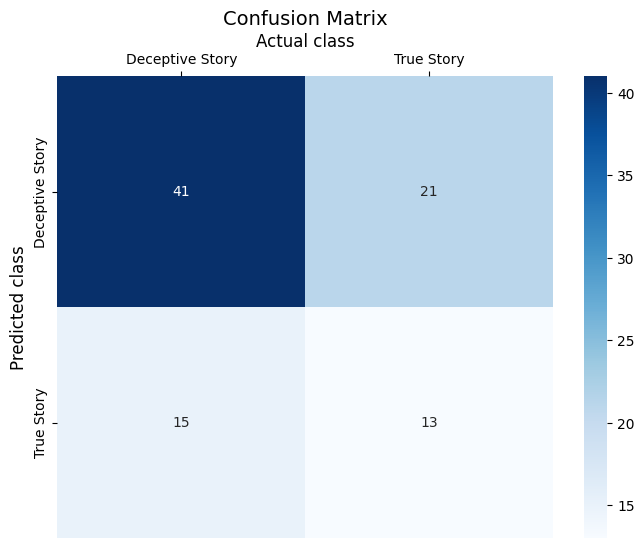

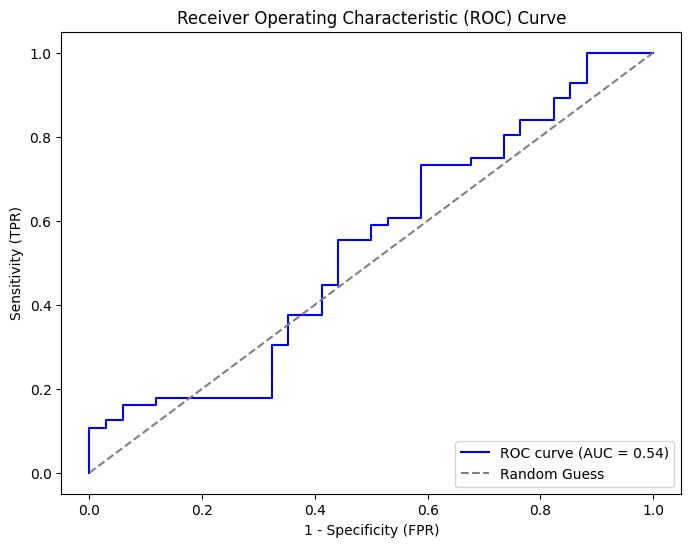


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,True Story,True Story,0.510024
1,True Story,True Story,0.548255
2,True Story,Deceptive Story,0.183930
3,True Story,Deceptive Story,0.145064
4,True Story,Deceptive Story,0.415040
...,...,...,...
85,Deceptive Story,Deceptive Story,0.054128
86,Deceptive Story,True Story,0.803251
87,True Story,True Story,0.720225
88,Deceptive Story,True Story,0.680986


In [34]:
pipeline.evaluate(X_test, y_test, test_models=["nn_model"])

Enabled models for evaluation: ['rf_model']
rf_model Predictions: [0.94 0.78 0.78 0.61 0.94 0.1  0.96 0.97 0.2  0.85 0.23 0.99 0.02 0.85
 0.92 0.07 0.6  0.5  0.92 0.19 0.   0.06 0.08 0.99 0.53 0.24 0.99 0.99
 0.19 0.78 0.56 0.95 0.01 0.67 0.98 0.2  0.83 0.04 0.92 0.53 0.9  0.32
 0.96 0.71 0.17 0.31 0.39 0.94 0.5  0.19 0.3  0.   0.93 0.85 0.35 0.81
 0.88 0.06 0.99 0.09 0.82 0.39 0.14 0.84 0.95 0.18 0.   0.08 0.99 0.78
 0.97 0.86 0.98 0.87 0.66 0.98 0.84 0.5  0.14 0.94 0.92 0.09 0.95 0.83
 0.83 0.24 0.37 0.99 0.08 0.7 ]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93        34
           1       0.98      0.93      0.95        56

    accuracy                           0.94        90
   macro avg       0.94      0.95      0.94        90
weighted avg       0.95      0.94      0.94        90

Confusion Matrix:
 [[33  1]
 [ 4 52]]
Sensitivity: 0.93
Specificity: 0.97
Precision: 0.98
F1 Scor

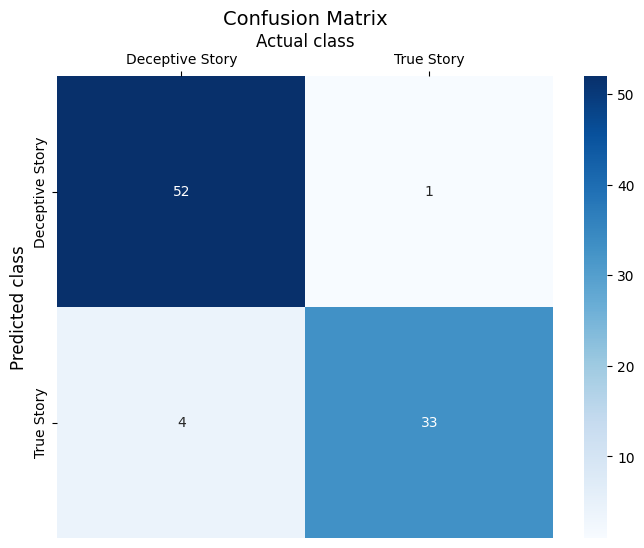

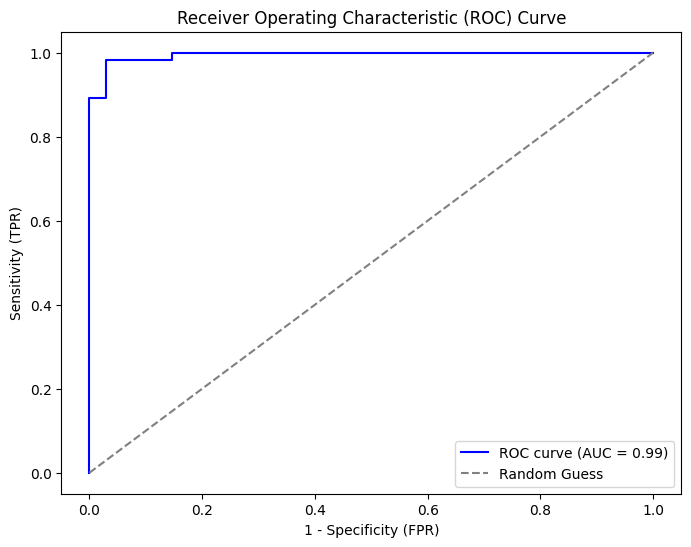


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,True Story,True Story,0.94
1,True Story,True Story,0.78
2,True Story,True Story,0.78
3,True Story,True Story,0.61
4,True Story,True Story,0.94
...,...,...,...
85,Deceptive Story,Deceptive Story,0.24
86,Deceptive Story,Deceptive Story,0.37
87,True Story,True Story,0.99
88,Deceptive Story,Deceptive Story,0.08


In [35]:
pipeline.evaluate(X_test, y_test, test_models=["rf_model"])

Enabled models for evaluation: ['knn_model']
knn_model Predictions: [1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0
 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85        34
           1       0.94      0.86      0.90        56

    accuracy                           0.88        90
   macro avg       0.87      0.88      0.87        90
weighted avg       0.89      0.88      0.88        90

Confusion Matrix:
 [[31  3]
 [ 8 48]]
Sensitivity: 0.86
Specificity: 0.91
Precision: 0.94
F1 Score: 0.90


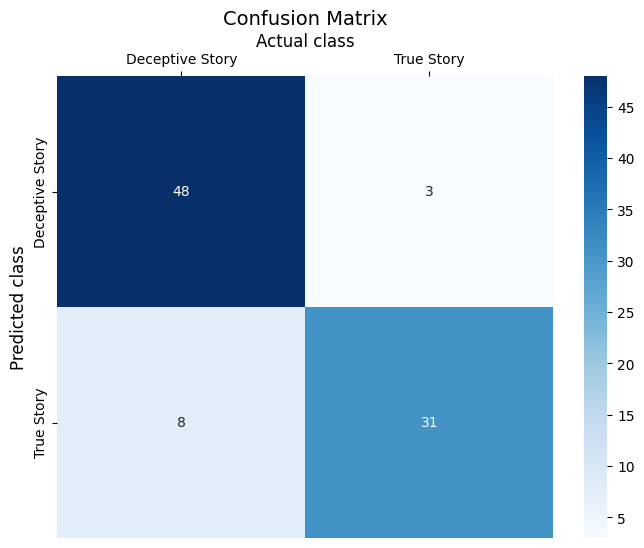

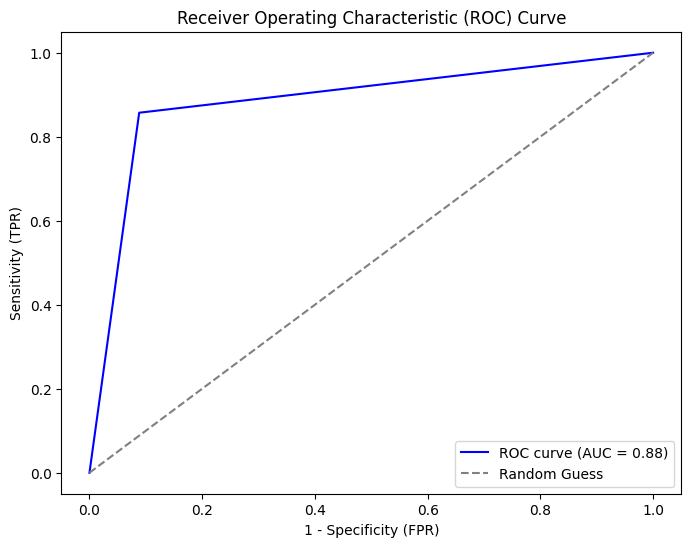


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,True Story,True Story,1.0
1,True Story,True Story,1.0
2,True Story,Deceptive Story,0.0
3,True Story,True Story,1.0
4,True Story,True Story,1.0
...,...,...,...
85,Deceptive Story,Deceptive Story,0.0
86,Deceptive Story,Deceptive Story,0.0
87,True Story,Deceptive Story,0.0
88,Deceptive Story,Deceptive Story,0.0


In [36]:
pipeline.evaluate(X_test, y_test, test_models=["knn_model"])

Enabled models for evaluation: ['lr_model']
lr_model Predictions: [1.00000000e+00 9.92975969e-01 1.00000000e+00 9.99999996e-01
 1.00000000e+00 1.68886846e-06 1.00000000e+00 1.00000000e+00
 2.63480144e-08 9.99999912e-01 5.36027262e-13 1.00000000e+00
 1.67690911e-09 1.00000000e+00 9.31804802e-01 6.65889010e-10
 1.09819360e-03 9.99997505e-01 1.00000000e+00 1.45478660e-14
 5.95461251e-12 1.43013353e-13 1.81463384e-18 9.99999999e-01
 1.00000000e+00 3.61226461e-15 9.99999965e-01 1.00000000e+00
 1.43844131e-14 9.99894406e-01 1.13816257e-01 1.00000000e+00
 6.31068862e-15 9.99999997e-01 9.99961077e-01 7.01105319e-09
 9.99999999e-01 1.46010999e-15 9.99999991e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 2.65058167e-10 7.27878129e-12 2.63673319e-13 1.00000000e+00
 9.99997505e-01 1.01146465e-19 2.16301547e-17 2.04944735e-17
 1.00000000e+00 1.00000000e+00 9.11947244e-16 9.99999770e-01
 9.99999995e-01 3.20637491e-10 1.00000000e+00 1.99241410e-10
 1.00000000e+00 3.2

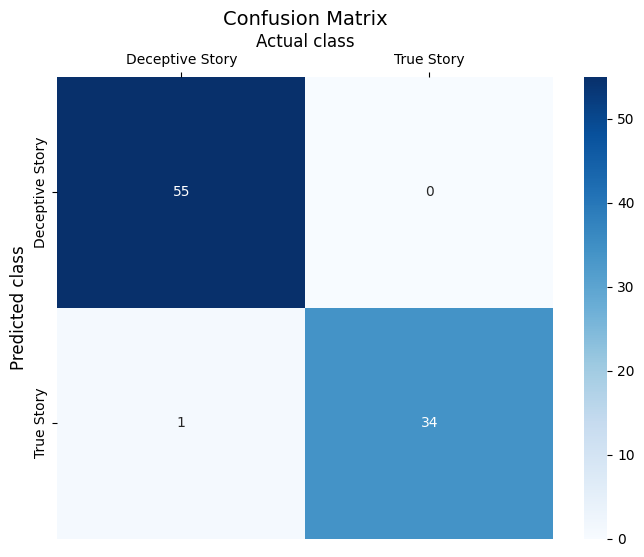

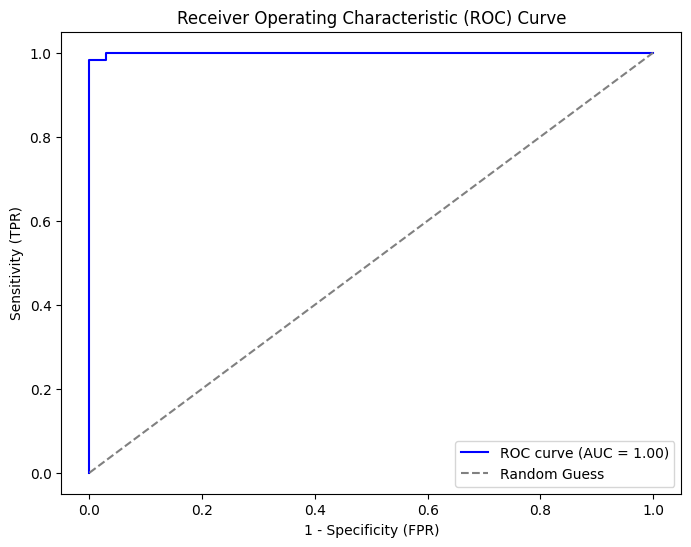


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,True Story,True Story,1.000000e+00
1,True Story,True Story,9.929760e-01
2,True Story,True Story,1.000000e+00
3,True Story,True Story,1.000000e+00
4,True Story,True Story,1.000000e+00
...,...,...,...
85,Deceptive Story,Deceptive Story,3.612265e-15
86,Deceptive Story,Deceptive Story,6.543843e-16
87,True Story,True Story,1.000000e+00
88,Deceptive Story,Deceptive Story,1.080913e-09


In [37]:
pipeline.evaluate(X_test, y_test, test_models=["lr_model"])

Enabled models for evaluation: ['svm_model']
svm_model Predictions: [1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0
 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80        34
           1       0.86      0.91      0.89        56

    accuracy                           0.86        90
   macro avg       0.85      0.84      0.84        90
weighted avg       0.85      0.86      0.85        90

Confusion Matrix:
 [[26  8]
 [ 5 51]]
Sensitivity: 0.91
Specificity: 0.76
Precision: 0.86
F1 Score: 0.89


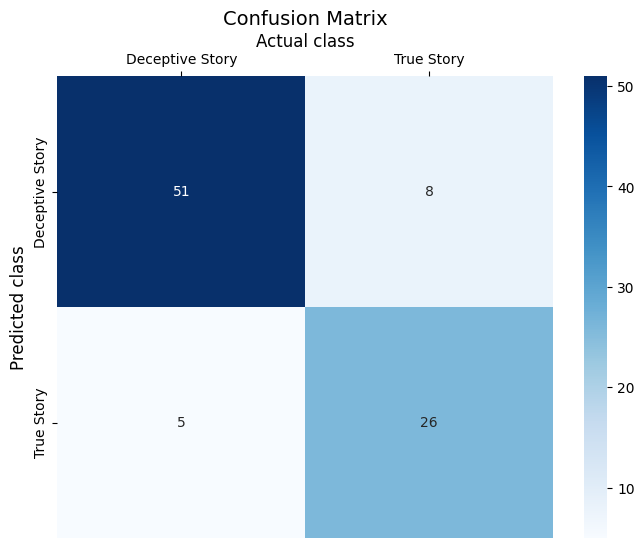

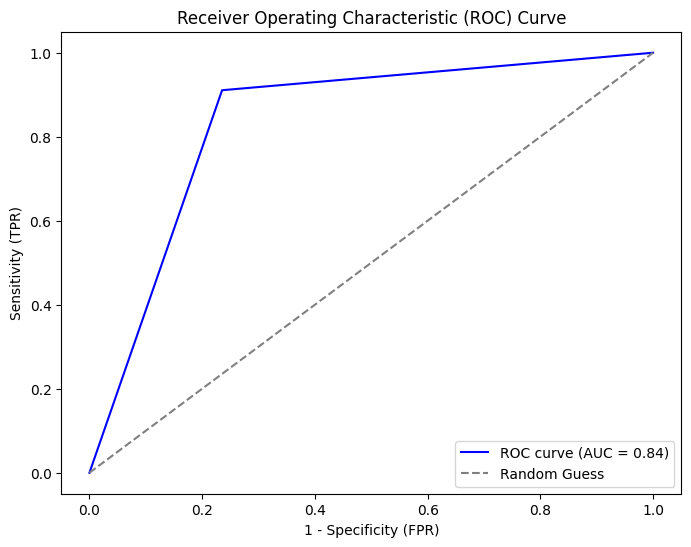


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,True Story,True Story,1.0
1,True Story,Deceptive Story,0.0
2,True Story,True Story,1.0
3,True Story,True Story,1.0
4,True Story,True Story,1.0
...,...,...,...
85,Deceptive Story,Deceptive Story,0.0
86,Deceptive Story,Deceptive Story,0.0
87,True Story,True Story,1.0
88,Deceptive Story,Deceptive Story,0.0


In [38]:
pipeline.evaluate(X_test, y_test, test_models=["svm_model"])

Enabled models for evaluation: ['nn_model', 'rf_model', 'knn_model', 'lr_model', 'svm_model']
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step
nn_model Predictions: [0.5100244  0.548255   0.18393049 0.145064   0.41504002 0.57889694
 0.71415883 0.72729754 0.7715776  0.68598145 0.10644924 0.57215005
 0.5493176  0.30206013 0.6439351  0.77527463 0.70186085 0.4396232
 0.69499433 0.7774336  0.12886058 0.5679039  0.35686594 0.76461136
 0.2749304  0.05412795 0.5294615  0.7656545  0.77741593 0.72407717
 0.81667817 0.886316   0.48654196 0.1753504  0.8597426  0.30174845
 0.8635697  0.47858045 0.81478316 0.52673835 0.4007317  0.34703404
 0.5352501  0.56866235 0.79677105 0.427793   0.7091083  0.51021874
 0.4396232  0.5014397  0.5510937  0.4418978  0.33742842 0.80987823
 0.79826885 0.72945917 0.82807183 0.72476685 0.75444275 0.70190555
 0.79824954 0.34994    0.76822335 0.737408   0.886316   0.5780675
 0.48699772 0.78653485 0.69139963 0.1839305  0.60160714 0.43106607
 0.6043491  0.5427049  0.73175824 0.85974634 0.5824544  0.5566443
 0.19523205 0.714833   0.6439351  0.8584579  0.23710902 0.48037004
 0.8

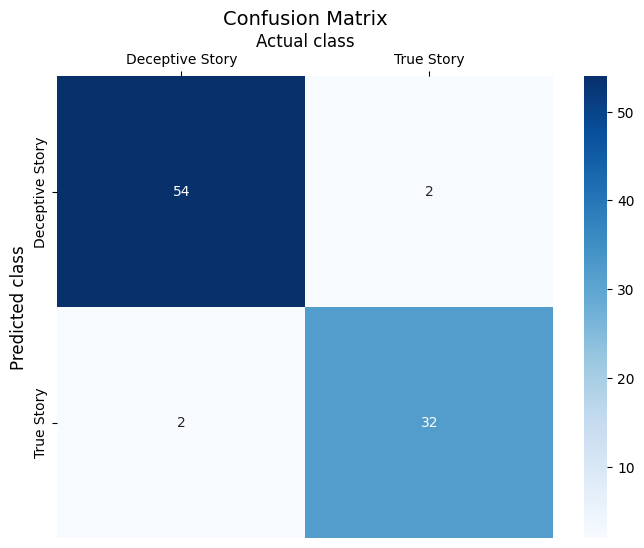

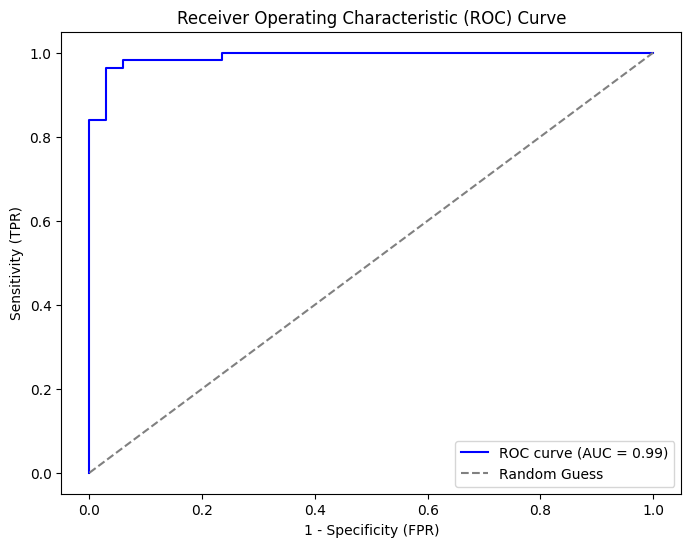


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,True Story,True Story,0.890005
1,True Story,True Story,0.664246
2,True Story,True Story,0.592786
3,True Story,True Story,0.751013
4,True Story,True Story,0.871008
...,...,...,...
85,Deceptive Story,Deceptive Story,0.058826
86,Deceptive Story,Deceptive Story,0.234650
87,True Story,True Story,0.742045
88,Deceptive Story,Deceptive Story,0.152197


In [39]:
pipeline.evaluate(X_test, y_test, test_models=["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"])

# 7 Conclusions

Your conclusions, suggestions for improvements, etc should go here.

# 8 References

Acknowledge others here (books, papers, repositories, libraries, tools) 